# Renewal Processes

A renewal process is a type of a stochastic (i.e. random) process. 

### Definition: Stochastic Process
Assume $(\Omega, \mathcal{F}, \mathbb{P})$, where $\Omega$ - a sample space, $ \mathcal{F}$ - a $\sigma$-algebra and $\mathbb{P}$ - a probability measure.

Then $X:\mathbb{R}\times \Omega  \rightarrow \mathbb{R}$ is a **random process** if $X(t, \cdot)$ is a random variable for each $t$.
### Definition: Renewal Process
$\{S_n\}_{n=0}^\infty$ is a **renewal process** if $S_0 = 0$ and $S_n = S_{n-1} + \xi_n$, where $\xi_1, \xi_2 \cdots$ are independent and identically distributed random variables with $\mathbb{P}(\xi_i >0) = 1$ for each $i$.
### Definition: Counting Process
We define the  **counting process** $\{N_t\}_{t=0}^\infty$ of a renewal process $\{S_n\}_{n=0}^\infty$  to be $N_t = max_{k}(S_k \leq t).$

*Example: Let the renewal process mark the times cars pass a point A on the motorway, where the $\xi_i$ is the time between the $i$-1-th and the $i$-th car. The counting process counts the number of cars that have driven past the point A.*

*Example: Let the renewal process mark the times when a stock jumps, where $\xi_i$ is the time between the $i$-1-th and the $i$-th jump. The counting process counts the number of jumps.*


We are now interested in the expected value of the counting process. We will first calculate it using the Monte Carlo process and later provide an analytical recipe for the calculation of the expected value.

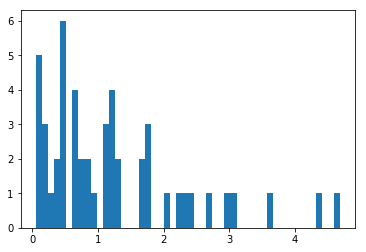

In [4]:
#Monte Carlo process code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
from scipy import stats
import math as math
import time

t0 = time.time()

%matplotlib inline

N = 50 #number or renewal process
M = 5000 #number of monte carlo repetitions
UNIT = 1

#Let's create a distribution of the times between the customers
def generate():
    if True:
        p_x = [rd.expovariate(1) for i in range(N)] # exponential distribution with lambda 1
        return p_x
    if False:
        p_x = [rd.expovariate(1)*0.5 + 0.5 *rd.expovariate(2)  for i in range(N)]
        return p_x
plt.hist(generate(), bins=50);
#Histogram of the distribution used

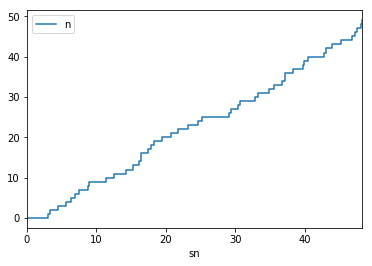

In [5]:
#Let's plot the counting process, based on the distribution above.
p_x = generate()
df = pd.DataFrame(p_x, columns = ["xi"])
df["sn"] = df.xi.cumsum()
df["n"] = [i for i in range(N)]
df.loc[0] = [0,0,0]
df.plot(drawstyle="steps-post", x = "sn", y = "n")
#x axis is the time, everytime s_i increases to s_i+1, n (on y axis) increases by 1

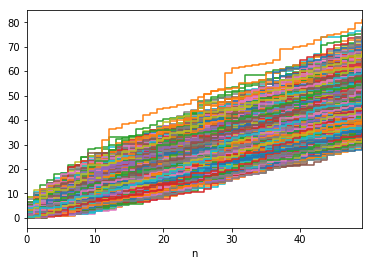

In [6]:
#we now generate M processes with n s_n points
ct = pd.DataFrame()
ct["n"] = [i for i in range(N)]
for i in range(M):
    x = "x" + str(i)
    sn = "s" + str(i)
    df[x] = generate()
    ct[sn] = df[x].cumsum()
ct.plot(drawstyle="steps-post", x = "n", legend = False)
#here, we plot the time on the y axis (due to plot limitations)

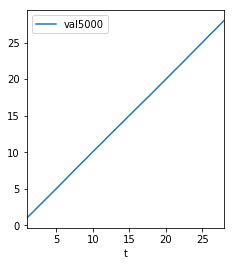

In [7]:
#now we compute the expected value of the counting process at time t
def exp_n(t):
    replace = ct["n"]
    ct.drop(columns="n")    
    ar = np.array(ct.values.tolist())
    sm = np.where(ar <= t, 1, 0).tolist()
    ct["n"] = replace
    return np.sum(sm)/M

#plot of the expected value using MC for different t
exp = pd.DataFrame()
limit = ct.max().min()
exp["t"] = np.arange(1, limit ,1)
exp["val"+str(M)] = [exp_n(t) for t in exp["t"]]
exp.plot(x = "t", y = ["val"+str(M)]).set_aspect('equal', adjustable='box')

### How to calculate the expected value of the counting process analitically?
Above, we calcualted the expected value using Monte Carlo simulations. 
Now, let's compute it analytically!

The computation involves 3 steps and some Laplace transforms [(What this?)](https://en.wikipedia.org/wiki/Laplace_transform).

1. Compute the Laplace transform $\mathcal{L}_p(s)$ of $p_{\xi_i}(x)$.

2. Transform the Laplace transform of $p_{\xi_i}(x)$ to  $\mathcal{L}_{U}(s) = \frac{\mathcal{L}_{p}(s)}{s(1-\mathcal{L}_{p}(s))}$.
3. Find the function $U(t)$, the inverse of the Laplace transform $\mathcal{L}_{U}(s)$. (*The most difficult part!*)

*Example:*
Let $S_n = S_{n-1} + \xi_n$ be a renewal process with $\xi_1, \xi_2, \dots$ IID random variables with an exponential distribution: $p_{\xi_i}(x) = \lambda e^{- \lambda x}$. What is the expected value of the $N_t$ counting process of the renewal process $S_n$?

1. $\mathcal{L}_p(s) = \int_0^\infty \lambda e^{- \lambda x} e^{-s x} dx = \lambda \int_0^\infty e^{- (\lambda +s)x} dx  = \frac{- \lambda}{\lambda + s} e^{- (\lambda +s)x} \Big|_0^\infty = \frac{\lambda}{\lambda +s}$

2. $\mathcal{L}_{U}(s) = \frac{\mathcal{L}_{p}(s)}{s(1-\mathcal{L}_{p}(s))} = \frac{\frac{\lambda}{\lambda +s}}{s(1-\frac{\lambda}{\lambda +s})} = \frac{\lambda}{s^2}$

3. $\mathcal{L}_{U}(s) \rightarrow U(t) = \lambda t$. Help: [Table of most famous transforms](https://en.wikipedia.org/wiki/Laplace_transform#Table_of_selected_Laplace_transforms). 

The function $U(t)$ is the expected value $E(N_t)$ we have been looking for!

In [8]:
#continuing the example lambda = 1
#we now plot the exact value for the expected value
def u(t, l = 1):
    return l * t
exp["u"] = [u(t) for t in exp["t"]]
exp["diff"] = exp["val"+str(M)] - exp["u"]

#used to measure time used to perform the calculations
t1 = time.time()
total = t1-t0
print(total)

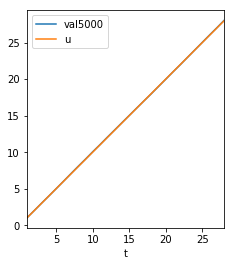

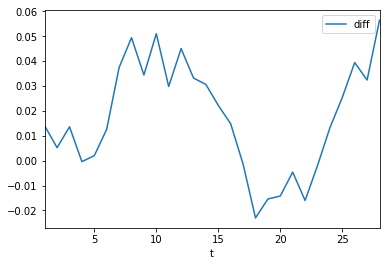

In [9]:
#Observe the error of the MC method
#plot both expected value using MC and the exact value
exp.plot(x = "t", y = ["val"+str(M), "u"]).set_aspect('equal', adjustable='box')
#plot the difference between the MC and the exact value
exp.plot(x = "t", y = "diff")

#### *Exercise*

What is the expected value of the counting process of the renewal process $S_n = S_{n-1} + \xi_n$, where $\xi_i$ are IID and have a probability density function: 
$p_{\xi}(x) = \begin{cases}
             0  & \text{if } x < 0 \\
             \frac{1}{2} e^{-x}(x+1)   & \text{if } x \ge 0
       \end{cases} \quad$ ?